In [112]:
# System operations
import inspect
import os
import uuid

# Date and time
from datetime import datetime

# type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML
from ipywidgets import IntProgress, Text, VBox

# Data manipulation
import math
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import random
import simplejson as json
import torch as th


# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import TabularQLearningWrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

In [113]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

In [114]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'
schema = DataSet().get_schema(DATASET_NAME)


In [115]:
# Building
root_directory = schema['root_directory']

# change the suffix number in the next code line to a
building_name = 'Building_1'

# Weather data
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
# Pricing data (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
# Carbon Intensity data
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
# building data
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())
display(building_data.describe(include='all'))

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature (C),Average Unmet Cooling Setpoint Difference (C),Indoor Relative Humidity (%),Equipment Electric Power (kWh),DHW Heating (kWh),Cooling Load (kWh),Heating Load (kWh),Solar Generation (W/kW),Occupant Count (people),Temperature Set Point (C),HVAC Mode (Off/Cooling/Heating)
0,6,1,2,0,22.428127,-0.794095,78.008001,0.356269,0.055730,0.000000,0.0,0.0,3.0,23.222222,1
1,6,2,2,0,22.223214,0.000992,79.042718,0.344522,0.159217,0.227737,0.0,0.0,3.0,22.222222,1
2,6,3,2,0,22.222226,0.000004,79.337523,0.338227,0.056899,0.132294,0.0,0.0,3.0,22.222222,1
3,6,4,2,0,22.222226,0.000004,79.581156,0.334329,0.000000,0.152979,0.0,0.0,3.0,22.222222,1
4,6,5,2,0,22.222226,0.000003,79.783525,0.348094,0.000000,0.119001,0.0,0.0,3.0,22.222222,1


,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature (C),Average Unmet Cooling Setpoint Difference (C),Indoor Relative Humidity (%),Equipment Electric Power (kWh),DHW Heating (kWh),Cooling Load (kWh),Heating Load (kWh),Solar Generation (W/kW),Occupant Count (people),Temperature Set Point (C),HVAC Mode (Off/Cooling/Heating)
count,2208.000000,2208.000000,2208.000000,2208.0,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.0,2208.000000,2208.000000,2208.000000,2208.0
mean,7.010870,12.500000,3.978261,0.0,24.127535,-0.018776,59.200654,0.611653,0.203282,2.832108,0.0,181.965621,2.285326,24.146311,1.0
std,0.814387,6.923755,2.000335,0.0,1.210651,0.171864,4.966167,0.814862,0.438131,1.643799,0.0,228.982415,0.846712,1.219651,0.0
min,6.000000,1.000000,1.000000,0.0,20.000008,-2.543717,45.069613,0.308113,0.000000,0.000000,0.0,0.000000,0.000000,20.000000,1.0
25%,6.000000,6.750000,2.000000,0.0,23.333403,-0.000026,56.135186,0.354607,0.000000,1.775248,0.0,0.000000,2.000000,23.333333,1.0
50%,7.000000,12.500000,4.000000,0.0,24.444372,0.000007,58.611239,0.403186,0.000000,2.550615,0.0,27.846772,3.000000,24.444444,1.0
75%,8.000000,18.250000,6.000000,0.0,24.444454,0.000090,61.912185,0.522546,0.203143,3.610280,0.0,388.286173,3.000000,24.444444,1.0
max,8.000000,24.000000,7.000000,0.0,27.222278,0.172056,80.558754,7.458969,4.529509,10.852755,0.0,712.919243,3.000000,27.222222,1.0


### Deep Q-Learning Agent
#### Reward Function


In [116]:
class CustomReward(RewardFunction):
    def __init__(self, capacity: float):
        self.capacity = capacity
        self.prev_net_load = None

    def __call__(self, obs: Mapping[str, float], action_frac: float) -> float:
        # 1) Net load & cost
        net_load   = obs['non_shiftable_load'] - action_frac*self.capacity # max: 11.25 kW
        price = obs['Electricity Pricing [$/kWh]'] # 0.06605 or 0.03025
        cost  = max(0.0, net_load) * price # deviation range: 0-11.25*0.06605 = ~0-0.75$
        #norm_cost = cost / 0.75 # normalize to [0,1]

        # multi-objective reinforcement learning (MORL) / multi-criteria optimization.

        # Comfort-Penalty
        # I use Category II of the Standard 16798-1/2 of REHVA using the PMV-PPD method for buildings with an active cooling system. 
        # Temperature in summer: 23-26 °C
        # Temperature in winter: 20-24 °C
        # deviation range: ~0-5 °C
        comfort_penalty = 0.0
        temp, rel_hum = obs['indoor_dry_bulb_temperature'], obs['indoor_relative_humidity']
        if temp<20: comfort_penalty += (20-temp) 
        if temp>24: comfort_penalty += (temp-24)
        norm_comfort_penalty = comfort_penalty / 5.0 # normalize to [0,1]

        # Relative Humidity: 40-60% 
        """
        if rel_hum<30: comfort_penalty += (40-rel_hum)*0.05
        if rel_hum>60: comfort_penalty += (rel_hum-60)*0.05
        """
        # Optional: Emissions, Ramping
        """
        emis = max(0.0, net_load) * obs['kg_CO2/kWh']
        if self.prev_net_load is None:
            ramp = 0.0
        else:
            ramp = abs(net_load - self.prev_net_load)
        self.prev_net_load = net_load
        """
        # weights
        w_cost, w_penalty = 0.5, 0.5
        #w_cost, w_pen, w_emis, w_ramp = 0.35, 0.35, 0.25, 0.05
        """
        - normalize to same scale
        - rework reward function: transform to same scale and test different weights
        - look into Stable Baselines 3 documentation for reward: 
        if it even converges to 0: hat probleme damit bei reward funktionen zu 0 zu konvergieren, 
        maximiert das immer gegen +/- unendlich
        - workaround: calculate cost without batterie/pv and with it and maximize the difference
        """
        # return -(w_cost*cost + w_pen*comfort_penalty + w_emis*emis + w_ramp*ramp)
        
        # return -(w_cost*norm_cost + w_penalty*norm_comfort_penalty)
        #return -norm_cost 
        return -cost
        '''
        price = obs['Electricity Pricing [$/kWh]']
        energy = action_frac * self.capacity  
        # >0 → entladen; <0 → laden

        # 1) Lade‑Kosten (negative reward), Entlade‑Erlös (positiver reward)
        reward_energy = energy * price

        # 2) Batterie‑Zyklus‑Kosten verhindern Ping‑Pong
        cycle_penalty = 0.05  # $ pro kWh
        reward_cycle  = - cycle_penalty * abs(energy)

        # 3) Gesamt‑Reward
        reward = reward_energy + reward_cycle

        # 4) (Optional) Normierung auf [-1,1]
        max_rev = self.capacity * obs['max_price']
        return reward / (max_rev + cycle_penalty * self.capacity)
        '''


In [117]:
'''
from citylearn.reward_function import ComfortReward, SolarPenaltyReward


class CustomReward(RewardFunction):
    """
    Parameters
    ----------
    env_metadata: Mapping[str, Any]:
        General static information about the environment.
    band: float, default = 2.0
        Setpoint comfort band (+/-). If not provided, the comfort band time series defined in the
        building file, or the default time series value of 2.0 is used.
    lower_exponent: float, default = 2.0
        Penalty exponent for when in cooling mode but temperature is above setpoint upper
        boundary or heating mode but temperature is below setpoint lower boundary.
    higher_exponent: float, default = 3.0
        Penalty exponent for when in cooling mode but temperature is below setpoint lower
        boundary or heating mode but temperature is above setpoint upper boundary.
    coefficients: Tuple, default = (1.0, 1.0)
        Coefficents for `citylearn.reward_function.SolarPenaltyReward` and :py:class:`citylearn.reward_function.ComfortReward` values respectively.
    """
    
    def __init__(self, env_metadata: Mapping[str, Any], band: float = None, lower_exponent: float = None, higher_exponent: float = None, coefficients: Tuple = None):
        super().__init__(env_metadata)
        # store our sub-reward functions in a single-underscore attr
        self._functions: List[RewardFunction] = [
            SolarPenaltyReward(env_metadata),
            # ComfortReward(env_metadata, band=band, lower_exponent=lower_exponent, higher_exponent=higher_exponent)
        ]
        self.coefficients = coefficients
        
    @property
    def coefficients(self) -> Tuple:
        return self.__coefficients
    
    @RewardFunction.env_metadata.setter
    def env_metadata(self, env_metadata: Mapping[str, Any]) -> Mapping[str, Any]:
        RewardFunction.env_metadata.fset(self, env_metadata)

        for f in self._functions:
            f.env_metadata = self.env_metadata
    
    @coefficients.setter
    def coefficients(self, coefficients: Tuple):
        coefficients = [1.0]*len(self._functions) if coefficients is None else coefficients
        assert len(coefficients) == len(self._functions), f'{type(self).__name__} needs {len(self._functions)} coefficients.' 
        self.__coefficients = coefficients

    def calculate(self, observations: List[Mapping[str, Union[int, float]]]) -> List[float]:
        reward = np.array([f.calculate(observations) for f in self._functions], dtype='float32')
        reward = reward*np.reshape(self.coefficients, (len(self.coefficients), 1))
        reward = reward.sum(axis=0).tolist()

        return reward
'''

'\nfrom citylearn.reward_function import ComfortReward, SolarPenaltyReward\n\n\nclass CustomReward(RewardFunction):\n    """\n    Parameters\n    ----------\n    env_metadata: Mapping[str, Any]:\n        General static information about the environment.\n    band: float, default = 2.0\n        Setpoint comfort band (+/-). If not provided, the comfort band time series defined in the\n        building file, or the default time series value of 2.0 is used.\n    lower_exponent: float, default = 2.0\n        Penalty exponent for when in cooling mode but temperature is above setpoint upper\n        boundary or heating mode but temperature is below setpoint lower boundary.\n    higher_exponent: float, default = 3.0\n        Penalty exponent for when in cooling mode but temperature is below setpoint lower\n        boundary or heating mode but temperature is above setpoint upper boundary.\n    coefficients: Tuple, default = (1.0, 1.0)\n        Coefficents for `citylearn.reward_function.SolarPen

#### DQN Environment
I wrap the DataFrames in a Gym Environment
following the same pattern as the tutorial’s Tabular QL wrapper,
but here I implement a custom `gym.Env` that emits a vector of normalized
features and accepts a *discrete* charge/discharge action.


In [118]:
from citylearn.reward_function import SolarPenaltyReward


class CityLearnDQNEnv(gym.Env):
    def __init__(self,
                 building_df: pd.DataFrame,
                 pricing_df:  pd.DataFrame,
                 weather_df:  pd.DataFrame,
                 carbon_df:   pd.DataFrame,
                 n_bins:      int = 5):
        super().__init__()
        # Data
        self.bld = building_df.reset_index(drop=True)
        self.prc = pricing_df.reset_index(drop=True)
        self.wth = weather_df.reset_index(drop=True)
        self.car = carbon_df.reset_index(drop=True)
        self.T   = len(self.bld) # number of timesteps in the environment

        self.n_bins     = n_bins
        self.action_space = spaces.Discrete(n_bins)

        # Observation space params
        self.obs_cols = [
            # building_df
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity',
            'non_shiftable_load', 'dhw_demand',
            'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'temperature_set_point', 'hvac_mode',
            # weather_df
            'outdoor_dry_bulb_temperature',
            'outdoor_relative_humidity',
            'diffuse_solar_irradiance',
            'direct_solar_irradiance',
            # carbon_df + pricing_df
            'kg_CO2/kWh',
            'Electricity Pricing [$/kWh]'
        ]
        self.obs_amount = len(self.obs_cols)
        self.bound = 5.0  # clip extreme outliers to ±5σ (cover 99.99994% of value)
        low  = -np.ones(self.obs_amount, dtype=np.float32) * self.bound
        high =  np.ones(self.obs_amount, dtype=np.float32) * self.bound

        # Observation space: Box of params, with every param having mean 0, std 1, bounds [-5, 5]
        self.observation_space = spaces.Box(low, high, dtype=np.float32)


        # Build a DataFrame of all observations to compute mean and std for each feature
        all_obs = pd.concat([
            self.bld[self.obs_cols[:15]],
            self.wth[self.obs_cols[15:19]],
            self.car[['kg_CO2/kWh']],
            self.prc[['Electricity Pricing [$/kWh]']]
        ], axis=1)
        # calculate mean and std for each feature
        self.obs_mean = all_obs.mean().values.astype(np.float32)
        self.obs_std  = all_obs.std().values.astype(np.float32)
        

        # simple battery
        self.capacity = 1.0
        self.soc      = 0.5
        
        self.reward_fn = CustomReward(capacity=self.capacity)
        #self.reward_fn = SolarPenaltyReward()
        
        #self.reward_fn = CustomReward(
            #env_metadata=env_metadata,
            # optionally: band=2.0, lower_exponent=2.0, higher_exponent=3.0,
            # coefficients=(1.0,)  # one entry per RewardFunction in CustomReward     
            #)

    def reset(self, seed=None, options=None):
        # Set seed if passed
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed) # reproducable randomness, not used yet TODO
        self.t   = 0
        self.soc = 0.5
        info = {}
        return self._get_obs(), info


    def _get_obs(self):
        row = {}
        
        for c in self.obs_cols[:15]:
            row[c] = self.bld.loc[self.t, c]
        for c in self.obs_cols[15:19]:
            row[c] = self.wth.loc[self.t, c]
        row['kg_CO2/kWh']               = self.car.loc[self.t, 'kg_CO2/kWh']
        row['Electricity Pricing [$/kWh]'] = self.prc.loc[self.t, 'Electricity Pricing [$/kWh]']

        x = np.array([row[c] for c in self.obs_cols], dtype=np.float32)
        
        # calculate z-score normalization (mean=0, std=1) and clip to ±5σ
        z = (x - self.obs_mean) / self.obs_std
        np.clip(x, -5.0, 5.0, out=x)

        return z


    def step(self, action):
        # 1) Aktion → frac
        frac = -1.0 + 2.0 * (action / (self.n_bins - 1)) # convert action [0, n] to the fraction of charge/discharge [-1, 1]

        # 2) SOC-Update
        self.soc = float(np.clip(self.soc + 0.1 * frac,
                                 0.0, self.capacity))

        # 3) Observation to dict
        obs_dict = {c: self.bld.loc[self.t, c] for c in [
            'non_shiftable_load',
            'indoor_dry_bulb_temperature',
            'indoor_relative_humidity',
        ]}
        # add price
        obs_dict['Electricity Pricing [$/kWh]'] = \
            self.prc.loc[self.t, 'Electricity Pricing [$/kWh]']
        obs_dict['kg_CO2/kWh'] = float(self.car.loc[self.t, 'kg_CO2/kWh'])

        # TODO: reward function outsourcing to CustomReward class
        # simple reward: minimize absolute net consumption
        net      = float(self.bld.loc[self.t, 'non_shiftable_load']) - frac * self.capacity
        price    = float(self.prc.loc[self.t, 'Electricity Pricing [$/kWh]'])
        
        # only pay for import, credit export at same rate
        #cost     = max(net, 0.0) * price - max(-net, 0.0) * price
        #reward   = -cost
        
        reward = self.reward_fn(obs_dict, frac)
        #reward = self.reward_fn.calculate(obs_dict) # Citylearn SolarPenaltyReward 

        #reward_list = self.reward_fn.calculate([obs_dict])
        #reward      = reward_list[0]

        
        # 5) Increase time and get next observation array
        self.t += 1
        terminated = (self.t >= self.T)
        truncated = False  # no time limit in this environment
        obs = self._get_obs() if not terminated else \
              np.zeros(len(self.obs_cols), dtype=np.float32)
        info = {}
        return obs, reward, terminated, truncated, info


    def render(self, mode='human'): pass


In [119]:
# Test how many outliers get clipped by the 5std bounds
# For building 1: 3 outliers
"""
# 1) Reconstruct your “observation” DataFrame in raw units
raw_df = pd.concat([
    bld[[
        'month', 'hour', 'day_type', 'daylight_savings_status',
        'indoor_dry_bulb_temperature',
        'average_unmet_cooling_setpoint_difference',
        'indoor_relative_humidity',
        'non_shiftable_load', 'dhw_demand',
        'cooling_demand', 'heating_demand',
        'solar_generation', 'occupant_count',
        'temperature_set_point', 'hvac_mode'
    ]].reset_index(drop=True),
    wth[[
        'outdoor_dry_bulb_temperature',
        'outdoor_relative_humidity',
        'diffuse_solar_irradiance',
        'direct_solar_irradiance'
    ]].reset_index(drop=True),
    car[['kg_CO2/kWh']].reset_index(drop=True),
    prc[['Electricity Pricing [$/kWh]']].reset_index(drop=True)
], axis=1)

# 2) Compute mean, std, ±5σ bounds, and actual min/max
stats = raw_df.describe().T[['mean','std']].copy()
stats['lower_5sigma'] = stats['mean'] - 5 * stats['std']
stats['upper_5sigma'] = stats['mean'] + 5 * stats['std']
stats['min']          = raw_df.min()
stats['max']          = raw_df.max()
stats['below_lower']  = stats['min']  < stats['lower_5sigma']
stats['above_upper']  = stats['max']  > stats['upper_5sigma']

# 3) See which features (if any) would get clipped:
print(stats[['mean','std','lower_5sigma','upper_5sigma','min','max','below_lower','above_upper']])
"""


"\n# 1) Reconstruct your “observation” DataFrame in raw units\nraw_df = pd.concat([\n    bld[[\n        'month', 'hour', 'day_type', 'daylight_savings_status',\n        'indoor_dry_bulb_temperature',\n        'average_unmet_cooling_setpoint_difference',\n        'indoor_relative_humidity',\n        'non_shiftable_load', 'dhw_demand',\n        'cooling_demand', 'heating_demand',\n        'solar_generation', 'occupant_count',\n        'temperature_set_point', 'hvac_mode'\n    ]].reset_index(drop=True),\n    wth[[\n        'outdoor_dry_bulb_temperature',\n        'outdoor_relative_humidity',\n        'diffuse_solar_irradiance',\n        'direct_solar_irradiance'\n    ]].reset_index(drop=True),\n    car[['kg_CO2/kWh']].reset_index(drop=True),\n    prc[['Electricity Pricing [$/kWh]']].reset_index(drop=True)\n], axis=1)\n\n# 2) Compute mean, std, ±5σ bounds, and actual min/max\nstats = raw_df.describe().T[['mean','std']].copy()\nstats['lower_5sigma'] = stats['mean'] - 5 * stats['std']\nstats

In [120]:
# 1) Spalten-Namen angleichen
bld = building_data.copy()
bld = bld.rename(columns={
    'Month': 'month',
    'Hour': 'hour',
    'Day Type': 'day_type',
    'Daylight Savings Status': 'daylight_savings_status',
    'Indoor Temperature (C)': 'indoor_dry_bulb_temperature',
    'Average Unmet Cooling Setpoint Difference (C)': 'average_unmet_cooling_setpoint_difference',
    'Indoor Relative Humidity (%)': 'indoor_relative_humidity',
    'Equipment Electric Power (kWh)': 'non_shiftable_load',
    'DHW Heating (kWh)': 'dhw_demand',
    'Cooling Load (kWh)': 'cooling_demand',
    'Heating Load (kWh)': 'heating_demand',
    'Solar Generation (W/kW)': 'solar_generation',
    'Occupant Count (people)': 'occupant_count',
    'Temperature Set Point (C)': 'temperature_set_point',
    'HVAC Mode (Off/Cooling/Heating)': 'hvac_mode'
})
# Kontroll-Ausgabe
print(bld.columns.tolist())

# 2) Wetterdaten umbenennen (falls nötig)
wth = weather_data.rename(columns={
    'Outdoor Drybulb Temperature (C)': 'outdoor_dry_bulb_temperature',
    'Outdoor Relative Humidity (%)':    'outdoor_relative_humidity',
    'Diffuse Solar Radiation (W/m2)':   'diffuse_solar_irradiance',
    'Direct Solar Radiation (W/m2)':    'direct_solar_irradiance',
})
prc = pricing_data.copy()
car = carbon_intensity_data.copy()


['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 'temperature_set_point', 'hvac_mode']


In [121]:
class TrainLoggerCallback(BaseCallback):
    """Loggt State, Action, Reward pro Schritt und Loss pro Update-Phase."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Für State/Action/Reward pro Timestep
        self.rows = []
        # Für Loss bei jedem internen Netz-Update
        self.losses = []
        self.loss_timesteps = []

         # NEW: episode returns
        self.episode_returns = []
        self._current_ep_return = 0.0

    def _on_step(self) -> bool:
        obs    = self.locals["new_obs"].flatten().tolist()
        action = int(self.locals["actions"][0])
        reward = float(self.locals["rewards"][0])
        step   = int(self.num_timesteps)

        # store state/action/reward
        row = { **{f"x{i}": obs[i] for i in range(len(obs))},
                "action": action,
                "reward": reward,
                "step": step }
        self.rows.append(row)

        # SB3 schreibt train/loss automatisch in self.logger.name_to_value
        current_loss = self.logger.name_to_value.get("train/loss")
        if current_loss is not None:
            self.losses.append(float(current_loss))
            self.loss_timesteps.append(step)

        #--- NEW: Episodic Returns ---
        self._current_ep_return += reward
        done = False
        # Bei Vektor‑Env: dones ist Array, hier Single‑Env -> [0]
        dones = self.locals.get("dones")
        if dones is not None:
            done = bool(dones[0])
        if done:
            # end of episode: save the return and reset counter
            self.episode_returns.append(self._current_ep_return)
            self._current_ep_return = 0.0

        return True

    def _on_training_end(self) -> None:
        # 1) DataFrame für State/Action/Reward
        # losses/timesteps bleiben als Listen/Arrays
        self.df = pd.DataFrame(self.rows)
        
        # 2) DataFrame for episodic Returns
        self.ep_df = pd.DataFrame({
            "episode": range(1, len(self.episode_returns) + 1),
            "return": self.episode_returns
        })
        super()._on_training_end()

In [122]:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DQN

def make_env(idx):
    def _init():
        env = CityLearnDQNEnv(
            building_df=bld,
            pricing_df=prc,
            weather_df=wth,
            carbon_df=car,
            n_bins=5
        )
        return Monitor(env)  # record episode stats
    return _init

# Launch parallel environments
"""
--- small cpu ---
1 => 46sec
2 => 34sec
3 => 32sec
4 => 36sec
8 => 46sec
16 => >4min

--- large cpu ---
3 => 28sec

"""
n_envs = 3
train_env = SubprocVecEnv([make_env(i) for i in range(n_envs)])
train_env = VecMonitor(train_env)
train_env = VecNormalize(
    train_env,
    norm_obs=True,      # observations on μ=0, σ=1
    norm_reward=True,   # Rewards on similar scale
    clip_obs=10.0       # clip extreme outliers
)


# Single-process eval env wrapped in Monitor
eval_env = DummyVecEnv([
    lambda: Monitor(
        CityLearnDQNEnv(
            building_df=bld,
            pricing_df=prc,
            weather_df=wth,
            carbon_df=car,
            n_bins=5
        )
    )
])
eval_env = VecMonitor(eval_env) 
eval_env = VecNormalize(
    eval_env,
    norm_obs=True,
    norm_reward=False,  # we want to see the real rewards during evaluation
    clip_obs=10.0
)

# Evaluate every 2k steps over 5 episodes
eval_callback = EvalCallback(
    eval_env,
    log_path="logs/eval/",
    best_model_save_path="logs/best_model/",
    #eval_freq=len(building_data), # run evaluation every 5k timesteps, TODO: change to 5_000
    eval_freq=2000, # run evaluation every 5k timesteps, TODO: change to 5_000
    n_eval_episodes=5,       # average over 5 full episodes
    deterministic=True,
    verbose=1
)

train_callback = TrainLoggerCallback()

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=3e-4, # slower to stabilize training
    buffer_size=100_000, # 
    batch_size=128, # 
    learning_starts=2_000, # start learning after 2000 steps, so enough experience is collected in replay-buffer
    train_freq= 256, # update the model every 256 steps
    target_update_interval= 500, # update the target network every 500 steps to avoid bull-whip effects (increasing oscillations)
    exploration_fraction= 0.3, # longer exploration until epsilon sinks to min value
    exploration_initial_eps= 1.0, # start with 100% exploration
    exploration_final_eps= 0.02, # near deterministic policy at the end
    gamma=0.98, # how much future rewards are discounted, 0.98 = 2% discount
    verbose=1, # 1 = info, 2 = debug
    policy_kwargs=dict(
        net_arch=[256, 256, 256],
        activation_fn=th.nn.ReLU,
        #dueling=True,
    ),
) 

# 5) Kick off training (each step is one env-step, so total_timesteps applies across all 4 envs)
T = len(building_data)            # episode length = 2208
total_timesteps = 10 * T          # 10*T = >30min on cpu, 37sec on lowest gpu
model.learn(
    #total_timesteps=total_timesteps,
    total_timesteps=100000,
    callback=CallbackList([train_callback, eval_callback])
)

print("Eval timesteps:", eval_callback.evaluations_timesteps)
print("Eval results   :", eval_callback.evaluations_results)

# 4) Evaluation results
# List of lists: each element are rewards from a eval round
all_rewards = eval_callback.evaluations_results
# timesteps at which the evaluations were run
eval_steps  = eval_callback.evaluations_timesteps

# Mean reward per round
mean_rewards = [np.mean(r) for r in all_rewards]

2025-07-15 16:19:39.946768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 16:19:39.960011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752589179.972821 3358222 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752589179.976639 3358222 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752589179.988453 3358222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Eval num_timesteps=6000, episode_reward=-120.56 +/- 0.00
Episode length: 2208.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.21e+03 |
|    mean_reward      | -121     |
| rollout/            |          |
|    exploration_rate | 0.804    |
| time/               |          |
|    total_timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | nan      |
|    n_updates        | 5        |
----------------------------------
New best mean reward!
Eval num_timesteps=12000, episode_reward=-120.56 +/- 0.00
Episode length: 2208.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.21e+03 |
|    mean_reward      | -121     |
| rollout/            |          |
|    exploration_rate | 0.608    |
| time/               |          |
|    total_timesteps  | 12000    |
| train/              |          |
|    lear

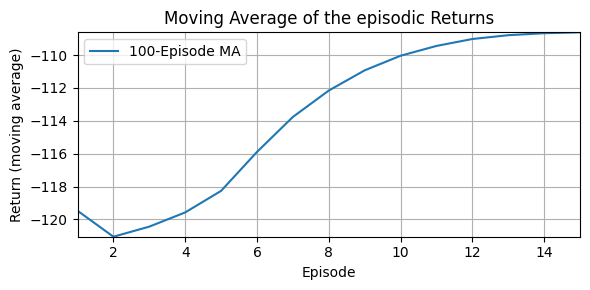

Total episodes: 15


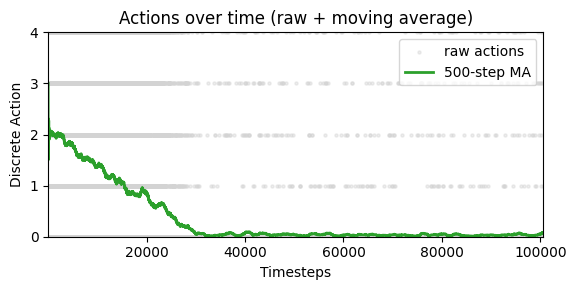

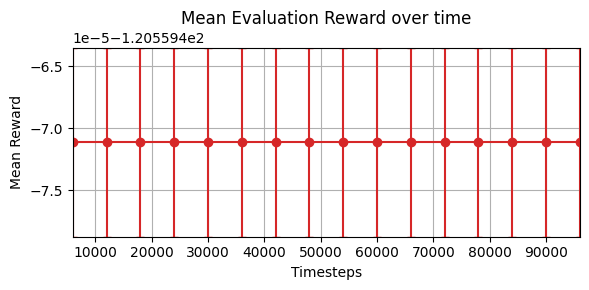

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# 1) TRAINING REWARD
window = 100
smooth = train_callback.ep_df["return"].rolling(window, min_periods=1).mean()
#train_df = train_callback.df  # your TrainLoggerCallback should have produced this
plt.figure(figsize=(6, 3))
plt.plot(train_callback.ep_df["episode"], smooth, label=f"{window}-Episode MA", color="C0")
#plt.plot(train_df["step"], train_df["reward"], color="C0")
plt.title("Moving Average of the episodic Returns")
#plt.title("Train Reward over time")
plt.xlabel("Episode")
#plt.xlabel("Timesteps")
plt.ylabel("Return (moving average)")
#plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
n_episodes = train_callback.ep_df["episode"].max()
print(f"Total episodes: {n_episodes}")
"""
# 2) TRAINING LOSS (if available)
if hasattr(train_callback, "losses") and len(train_callback.losses) > 0:
    plt.figure(figsize=(6, 3))
    plt.plot(train_callback.loss_timesteps,
             train_callback.losses,
             marker='.', linestyle='-',
             alpha=0.7, color="C1")
    plt.title("Train Loss over time")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""
train_df = train_callback.df  # your TrainLoggerCallback should have produced this


# 3) ACTIONS (raw + moving average)
plt.figure(figsize=(6, 3))
# raw scatter
plt.scatter(
    train_df["step"],
    train_df["action"],
    c="lightgray", s=5, alpha=0.4,
    label="raw actions"
)
# moving average
window = 500
train_df["action_ma"] = train_df["action"].rolling(window, min_periods=1).mean()
plt.plot(
    train_df["step"],
    train_df["action_ma"],
    color="C2", lw=2,
    label=f"{window}-step MA"
)
plt.title("Actions over time (raw + moving average)")
plt.xlabel("Timesteps")
plt.ylabel("Discrete Action")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 4) EVALUATION REWARD
all_eval = eval_callback.evaluations_results        # list of lists
steps    = eval_callback.evaluations_timesteps      # list of ints

# compute per‐evaluation mean/std
mean_eval = [float(np.mean(r)) for r in all_eval]
std_eval  = [float(np.std(r))  for r in all_eval]

plt.figure(figsize=(6, 3))
plt.errorbar(
    steps, mean_eval,
    yerr=std_eval,
    fmt='-o', capsize=3, color="C3",
    label="Eval mean ±1σ"
)
plt.title("Mean Evaluation Reward over time")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


### (Right now Unnecessary) Visualizations 

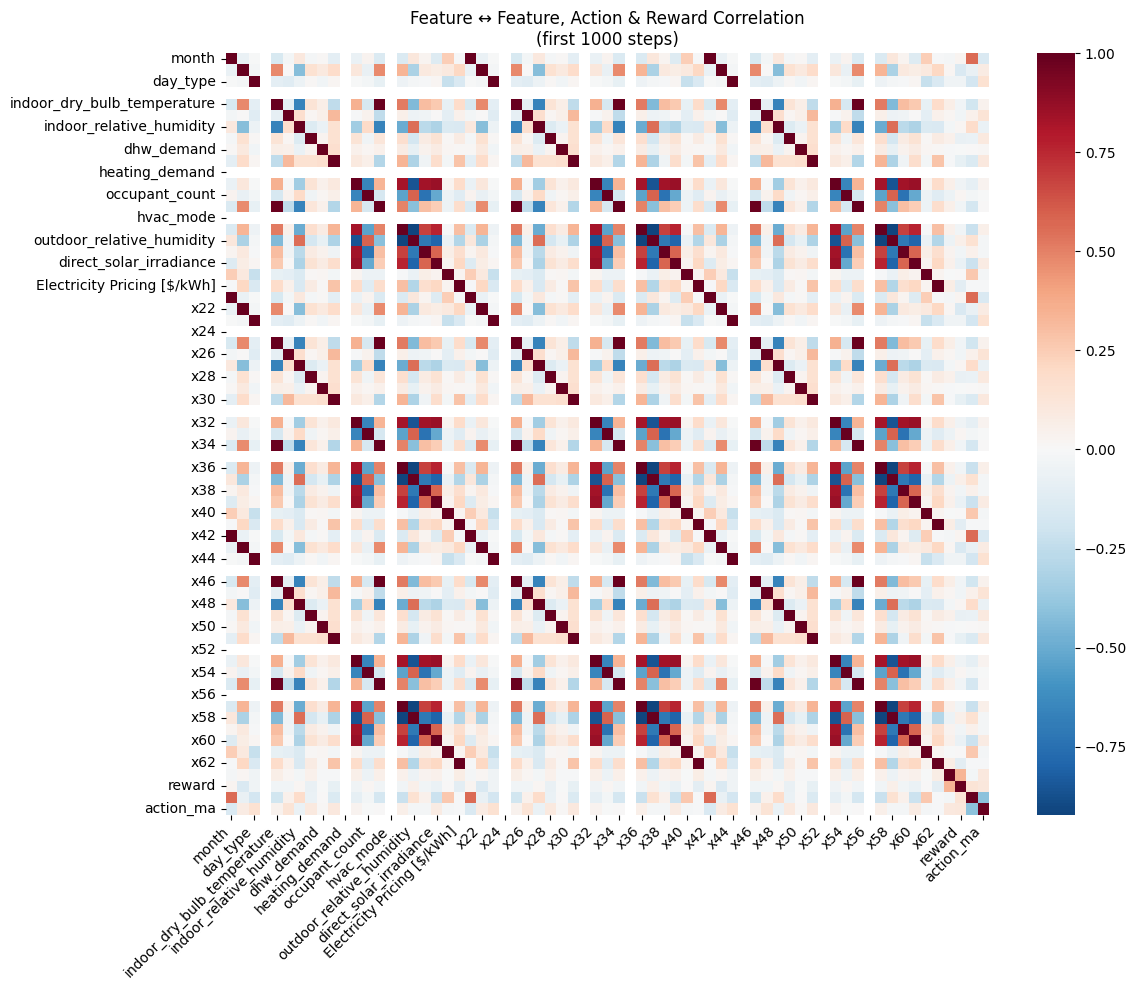

In [124]:
# heatmap of feature correlations
import seaborn as sns

real_labels = [
    'month','hour','day_type','daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load','dhw_demand',
    'cooling_demand','heating_demand',
    'solar_generation','occupant_count',
    'temperature_set_point','hvac_mode',
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance','direct_solar_irradiance',
    'kg_CO2/kWh','Electricity Pricing [$/kWh]'
]
mapping    = {f"x{i}": real_labels[i] for i in range(len(real_labels))}
mapping.update({"action":"action","reward":"reward"})
train_df.rename(columns=mapping, inplace=True)

# Zeitfenster
sub = train_df.iloc[:1000]

# Korrelation berechnen
corr = sub.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    cmap="RdBu_r",
    center=0
)
plt.title("Feature ↔ Feature, Action & Reward Correlation\n(first 1000 steps)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Which features are correlated and typically change together?

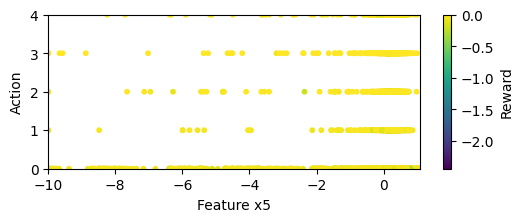

In [125]:
# Plot one feature vs action and reward
plt.figure(figsize=(6,2))
plt.scatter(train_df["average_unmet_cooling_setpoint_difference"], train_df["action"], c=train_df["reward"], cmap="viridis", s=10)
plt.colorbar(label="Reward")
plt.xlabel("Feature x5")
plt.ylabel("Action")
plt.show()

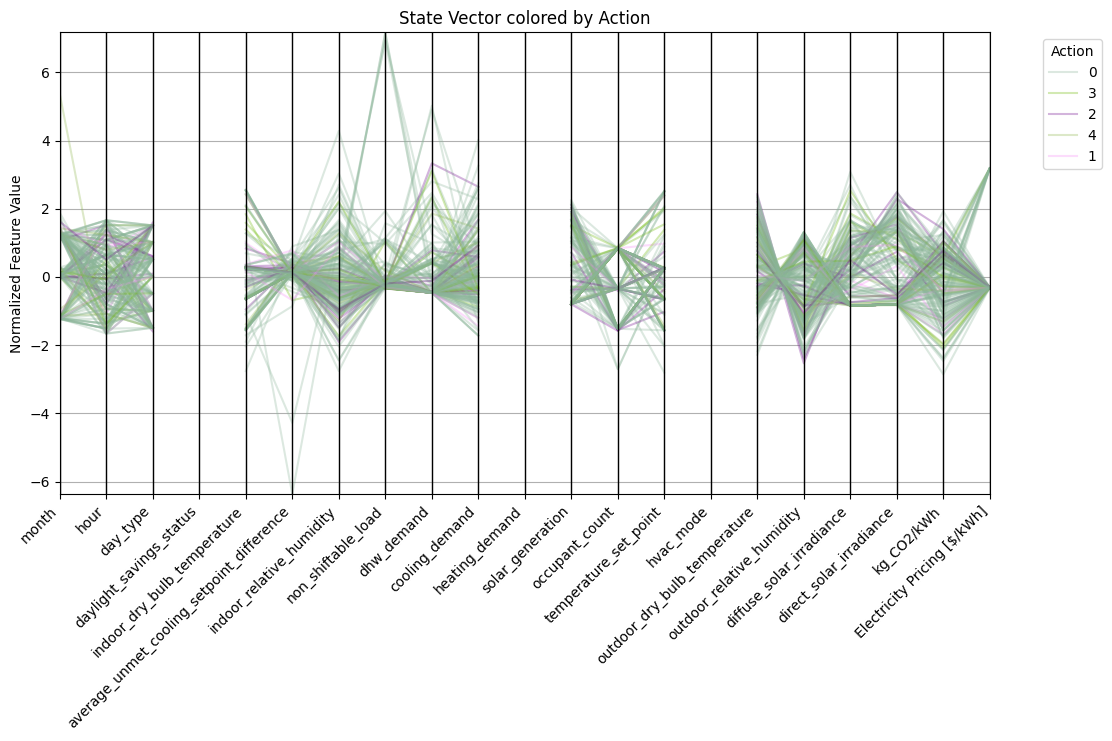

In [126]:
# Parallel Coordinates Plot: color by target action
from pandas.plotting import parallel_coordinates

obs_cols = train_env.get_attr("obs_cols")[0] # feature names
rename_map = { f"x{i}": obs_cols[i] for i in range(len(obs_cols)) }
df_named = train_df.rename(columns=rename_map)

# 200 random samples from the training DataFrame
sample = df_named.sample(200, random_state=0).copy()
# convert action to string for coloring
sample["action"] = sample["action"].astype(str)

plt.figure(figsize=(12,6))
parallel_coordinates(
    sample,
    class_column="action",
    #cols=[f"x{i}" for i in range(len(sample.columns) - 4)],  # x0…xN
    cols=obs_cols,
    alpha=0.3,
)
plt.title("State Vector colored by Action")
plt.ylabel("Normalized Feature Value")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Action", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


In [127]:
# Currently broken
"""
from sklearn.decomposition import PCA

# 1) Mapping von x0…xN auf die echten Feature-Namen
mapping = { f"x{i}": obs_cols[i] for i in range(len(obs_cols)) }
df_renamed = train_df.rename(columns=mapping)



# Features x0…xN
X = df_renamed[[c for c in df_renamed.columns if c.startswith("x")]].values
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)

plt.figure(figsize=(6,5))
sc = plt.scatter(
    pcs[:,0], pcs[:,1],
    c=train_df["action"], cmap="tab10",
    s=10, alpha=0.6
)
plt.colorbar(sc, label="Action")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.title("PCA-Projektion der Zustände, eingefärbt nach Aktion")
plt.show()


# 2D PCA Projection of States colored by Reward
# Each point represents a state, colored by the action taken in that state
"""

'\nfrom sklearn.decomposition import PCA\n\n# 1) Mapping von x0…xN auf die echten Feature-Namen\nmapping = { f"x{i}": obs_cols[i] for i in range(len(obs_cols)) }\ndf_renamed = train_df.rename(columns=mapping)\n\n\n\n# Features x0…xN\nX = df_renamed[[c for c in df_renamed.columns if c.startswith("x")]].values\npca = PCA(n_components=2)\npcs = pca.fit_transform(X)\n\nplt.figure(figsize=(6,5))\nsc = plt.scatter(\n    pcs[:,0], pcs[:,1],\n    c=train_df["action"], cmap="tab10",\n    s=10, alpha=0.6\n)\nplt.colorbar(sc, label="Action")\nplt.xlabel("PCA 1"); plt.ylabel("PCA 2")\nplt.title("PCA-Projektion der Zustände, eingefärbt nach Aktion")\nplt.show()\n\n\n# 2D PCA Projection of States colored by Reward\n# Each point represents a state, colored by the action taken in that state\n'